# TensoRF Color Variance

## Imports

In [1]:
import math
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

from models.tensoRF import TensorVMSplit

In [2]:
torch.set_default_dtype(torch.float32)
torch.manual_seed(20211202)
np.random.seed(20211202)

## Load Model

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ckpt = torch.load('trained_models/tensorf_trex_VM.th', map_location=device)
kwargs = ckpt['kwargs']
kwargs.update({'device': device})
tensorf = TensorVMSplit(**kwargs)
tensorf.load(ckpt)

aabb tensor([-1.5000, -1.6700, -1.0000,  1.5000,  1.6700,  1.0000], device='cuda:0')
grid size [706, 786, 471]
sampling step size:  tensor(0.0021, device='cuda:0')
sampling number:  2311
pos_pe 6 view_pe 0 fea_pe 0
MLPRender_Fea(
  (mlp): Sequential(
    (0): Linear(in_features=30, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=3, bias=True)
  )
)


## Find Color Variance

In [4]:
ray = torch.tensor([[ 1.2144,  1.4356, -1.0000, -0.5, -0.5,  1.0000]]).to(device) # x,y,z, dx,dy,dz

In [5]:
with torch.no_grad():
    tensorf.eval()
    output = tensorf.forward(ray)

rgb_map, depth, rgb, sigma, xyz_sampled = output

rgb = rgb[0].cpu().numpy()
sigma = sigma[0].cpu().numpy()
xyz_sampled = xyz_sampled[0].cpu().numpy()


## Graphical Data Views

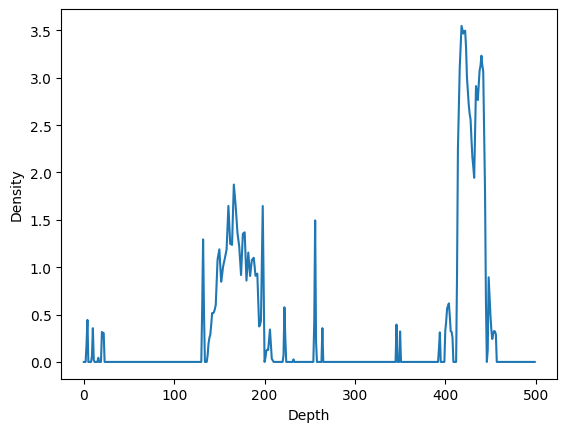

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlabel('Depth')
ax.set_ylabel('Density')

ax.plot(sigma[:500])

plt.show()

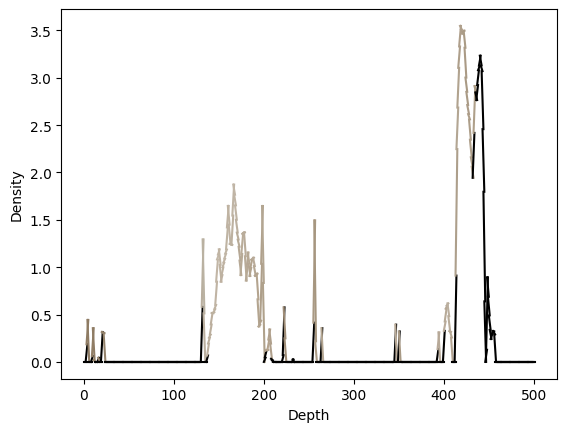

In [7]:
fig_col = plt.figure()
ax = fig_col.add_subplot(111)

ax.set_xlabel('Depth')
ax.set_ylabel('Density')

# ax.set_ylim(0, 1)
for i in range(len(sigma[:500])):
    ax.plot([i,i+2],sigma[i:i+2],color=(tuple(rgb[i])))

plt.show()

In [8]:
for i, val in enumerate(sigma):
    if val > 0.006:
        print(i)

3
4
9
10
11
16
20
21
22
131
132
133
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
201
202
203
204
205
206
207
208
209
221
222
223
232
255
256
257
264
346
350
393
394
400
401
402
403
404
405
406
407
408
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
447
448
449
450
451
452
453
454
455
456
607
608
609
610
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
922
923
924
925


In [9]:
variance_depth = 25
xyz = xyz_sampled[variance_depth]
xyz = torch.tensor(xyz).to(device).view(1,3)

sampled_ray = ray[0].cpu().numpy()
testing_views = []
size = 90
for i in range(size**2):
    testing_views.append([(((i%size)-45)/360)+sampled_ray[3], ((int(i/size)-45)/360)+sampled_ray[4], sampled_ray[5]])

testing_views = torch.tensor(testing_views, dtype=torch.float32).to(device)

variance_map = []
with torch.no_grad():
    tensorf.eval()
    for view in testing_views:
        testing_view = torch.tensor(view).to(device).view(1,3)
        variance_map.append(tensorf.get_variance(xyz, testing_view)[0].cpu().numpy())
    variance_map = np.array(variance_map)

C:\Users\alexk\AppData\Local\Temp\ipykernel_11640\1054049633.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testing_view = torch.tensor(view).to(device).view(1,3)


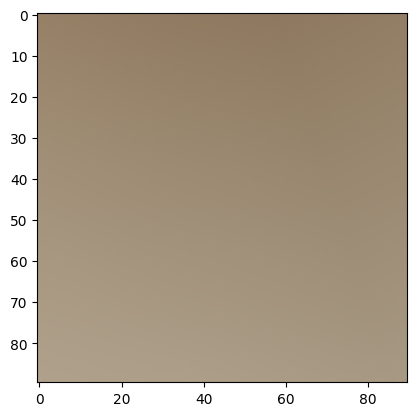

In [10]:
variance_map = variance_map.reshape(size,size,3)
imgplot = plt.imshow(variance_map)

In [11]:
from IPython.display import display, HTML

rays0 = np.load('legorays.npy')
df = pd.DataFrame(rays0)
display(df)
print(rays0[0][0] - rays0[1][0])
print(rays0[1][0] - rays0[2][0])

,0,1,2,3,4,5
0,-0.827720,3.885238,0.685426,0.248751,-0.963103,-0.102742
1,-3.355160,-2.052627,0.882965,0.924620,0.370135,0.089874
2,3.168010,-2.172287,1.222655,-0.809724,0.383956,-0.443761
3,-3.886371,-0.826070,0.680976,0.998615,-0.050368,0.015220
4,-0.792851,3.892266,0.686769,0.002598,-0.998930,0.046174
...,...,...,...,...,...,...
4091,2.103101,-1.032314,3.280441,-0.609478,0.448610,-0.653671
4092,-0.792851,3.892266,0.686769,0.285939,-0.919404,-0.270064
4093,2.886523,2.513217,1.265593,-0.584735,-0.779664,-0.224074
4094,-2.065626,3.293685,1.065282,0.438006,-0.801215,-0.407682


2.52744
-6.523169


In [18]:
testing_rays = []
size = 512 #1024
for i in range(size):
    for j in range(size):
        testing_rays.append([1.5-j/size*2, 1.5-i/size*2, -1.7500, -0.5, -0.5,  2.0000])

testing_rays = torch.tensor(testing_rays, dtype=torch.float32).to(device)
testing_rays = testing_rays.view(-1, int(4096/size)*size, 6)

output = []
with torch.no_grad():
    tensorf.eval()
    for ray in tqdm(testing_rays):
        output.append(tensorf(ray)[0].cpu().numpy())

100%|██████████| 64/64 [00:02<00:00, 24.49it/s]


In [13]:
aabb = [-0.6732, -1.1929, -0.4843,  0.6732,  1.1929,  1.0512]

testing_rays = []
size = 512 #1024
for i in range(size):
    for j in range(size):
        testing_rays.append([2-j/size, -1, 3-i/size*2, -0.5, 0.5, -0.5])

testing_rays = torch.tensor(testing_rays, dtype=torch.float32).to(device)
testing_rays = testing_rays.view(-1, int(4096/size)*size, 6)

output = []
with torch.no_grad():
    tensorf.eval()
    for ray in tqdm(testing_rays):
        output.append(tensorf(ray)[0].cpu().numpy())

100%|██████████| 64/64 [00:07<00:00,  8.94it/s]


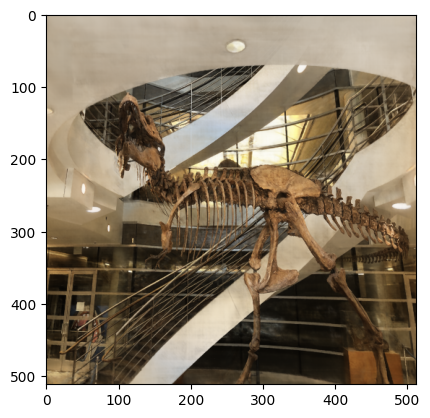

In [19]:
rgb_map = np.array(output)
rgb_map = rgb_map.reshape(size,size,3)
imgplot = plt.imshow(rgb_map)

In [15]:
img = Image.fromarray((rgb_map*255).astype(np.uint8))
img.save("trex.png")